# SkimLit
NLP model to make reading medical abstracts easier.

Datasets: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1c6a3ea4-8fbb-9c61-94aa-812504b93e9f)


In [2]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct
! ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 13.21 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
! ls pubmed-rct/PubMed_20k_RCT
! ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
import os
file_names = [os.path.join(data_dir, file_dir) for file_dir in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
TRAIN_PATH = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
TEST_PATH = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt"
DEV_PATH = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt"

In [7]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
train_lines = get_lines(TRAIN_PATH)
test_lines = get_lines(TEST_PATH)
dev_lines = get_lines(DEV_PATH)

In [9]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Data representation:
```
[{
  'line_number': 0,
  'target' : 'BACKGROUND',
  'text' : "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_words' : 11
}]
```


In [22]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [24]:
%%time
train_samples = preprocess_text_with_line_numbers(TRAIN_PATH)
val_samples = preprocess_text_with_line_numbers(DEV_PATH) # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(TEST_PATH)
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 693 ms, sys: 114 ms, total: 807 ms
Wall time: 821 ms


(180040, 30212, 30135)

In [25]:
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [26]:
import pandas as pd
train_df = pd.DataFrame(train_samples)    
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [27]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [28]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

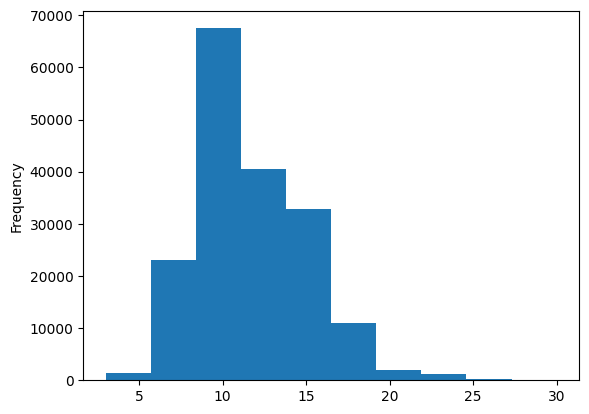

In [31]:
train_df["total_lines"].plot(kind="hist");

In [88]:
train_sentences = train_df["text"].values
val_sentences = val_df["text"].values
test_sentences = test_df["text"].values

In [67]:
train_sentences[:10]

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
       'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) we

In [68]:
# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder

In [69]:
one_hot_encoder = OneHotEncoder(sparse_output=False) # sparse=False because tf has problems with sparse matrix conversion to tensor

In [70]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].values.reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].values.reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].values.reshape(-1,1))

In [71]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [72]:
one_hot_encoder.get_feature_names_out()

array(['x0_BACKGROUND', 'x0_CONCLUSIONS', 'x0_METHODS', 'x0_OBJECTIVE',
       'x0_RESULTS'], dtype=object)

In [73]:
# Label encoding the labels
from sklearn.preprocessing import LabelEncoder

In [74]:
label_encoder = LabelEncoder()

In [75]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].values)
val_labels_encoded = label_encoder.transform(val_df["target"].values)
test_labels_encoded = label_encoder.transform(test_df["target"].values)

In [76]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [77]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Model 0 : TF-IDF + Naive Bayes

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [82]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", MultinomialNB())
])

In [84]:
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [85]:
model_0.score(train_sentences, train_labels_encoded)

0.7516829593423684

In [86]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [89]:
model_0.score(test_sentences, test_labels_encoded)

0.716674962667994

In [90]:
predictions = model_0.predict(val_sentences)
predictions

array([4, 1, 3, ..., 4, 4, 1])

In [91]:
print(classification_report(val_labels_encoded, predictions))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56      3449
           1       0.65      0.59      0.61      4582
           2       0.72      0.87      0.79      9964
           3       0.75      0.14      0.23      2376
           4       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



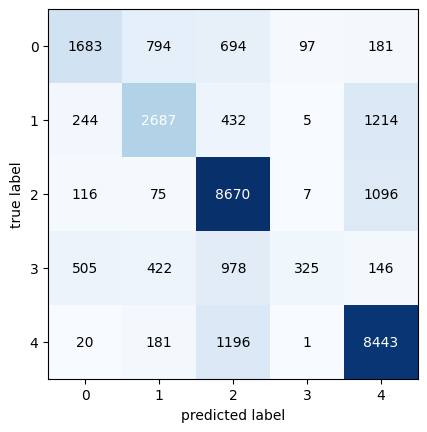

In [95]:
plot_confusion_matrix(confusion_matrix(val_labels_encoded, predictions));